# Proyek Analisis Data: [E-Commerce]
- **Nama:** [Yoga Samudra]
- **Email:** [08samudra@gmail.com]
- **ID Dicoding:** [08samudra]

## Menentukan Pertanyaan Bisnis

- Kota mana yang meghasilkan nilai penjualan tertinggi dan menyumbang setidaknya 10% dari total nilai transaksi penjualan secara keseluruhan?
- Di kota tersebut, produk apa yang paling dominan, yaitu yang menyumbang minimal 50% dari total nilai transaksi penjualan di kota tersebut?

## Import Semua Packages/Library yang Digunakan

In [4]:
%pip install squarify

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import squarify
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'seaborn'

## 1. Data Wrangling

### 1.1 Gathering Data

In [7]:
customers = pd.read_csv("datasets/customers_dataset.csv")
geolocation = pd.read_csv("datasets/geolocation_dataset.csv")
order_items = pd.read_csv("datasets/order_items_dataset.csv")
order_payments = pd.read_csv("datasets/order_payments_dataset.csv")
order_reviews = pd.read_csv("datasets/order_reviews_dataset.csv")
orders = pd.read_csv("datasets/orders_dataset.csv")
product_category_name_translation = pd.read_csv("datasets/product_category_name_translation.csv")
products = pd.read_csv("datasets/products_dataset.csv")
sellers = pd.read_csv("datasets/sellers_dataset.csv")

**Insight:**
Berdasarkan data yang diimport, kita akan menggunakan dataset sebagai berikut, untuk menjadi pertanyaan yang telah didefinisikan.
- customers,
- order_items,
- orders,
- order_payments, dan
- products

### 1.2 Assessing Data

Memeriksa data sperti:
- Informasi Tipe Data
- Data Duplikat
- Nilai yang Hilang

In [8]:
dataframes_to_assess = {
    "customers": customers,
    "order_items": order_items,
    "orders": orders,
    "order_payments": order_payments,
    "products": products
}

print("--- Memulai Proses Assessing Data untuk DataFrame Pilihan ---")
print("-" * 60) # Garis pemisah

for df_name, df_data in dataframes_to_assess.items():
    print(f"\n===== Assessing DataFrame: {df_name} =====")
    print("----------------------------------------------------------------------")

    # 1. Periksa Informasi Tipe Data
    print("\n--- 1. Informasi Tipe Data (df.info()) ---")
    df_data.info()

    # 2. Periksa Data Duplikat (Baris Duplikat Penuh)
    num_duplicates = df_data.duplicated().sum()
    print(f"\n--- 2. Jumlah Baris Duplikat Penuh: {num_duplicates} ---")
    if num_duplicates > 0:
        print(f"  Ditemukan {num_duplicates} baris duplikat di DataFrame '{df_name}'.")
    else:
        print(f"  Tidak ada baris duplikat di DataFrame '{df_name}'.")

    # 3. Periksa Nilai yang Hilang (Jumlah dan Persentase)
    missing_values = df_data.isnull().sum()
    missing_percentage = (missing_values / len(df_data)) * 100

    print("\n--- 3. Jumlah dan Persentase Nilai yang Hilang per Kolom ---")
    if missing_values.sum() == 0:
        print(f"  Tidak ada nilai yang hilang di DataFrame '{df_name}'.")
    else:
        missing_info = pd.DataFrame({
            'Jumlah Hilang': missing_values,
            'Persentase Hilang (%)': missing_percentage
        })
        print(missing_info[missing_info['Jumlah Hilang'] > 0].sort_values(by='Persentase Hilang (%)', ascending=False))

    print("\n" + "=" * 60) # Garis pemisah antar DataFrame

print("\n--- Proses Assessing Data Selesai ---")

--- Memulai Proses Assessing Data untuk DataFrame Pilihan ---
------------------------------------------------------------

===== Assessing DataFrame: customers =====
----------------------------------------------------------------------

--- 1. Informasi Tipe Data (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB

--- 2. Jumlah Baris Duplikat Penuh: 0 ---
  Tidak ada baris duplikat di DataFrame 'customers'.

--- 3. Jumlah dan Persentase Nilai yang Hilang per Kolom ---
  Tidak ada nilai yang h

**Insight: Assessing Data**
- Customers DataFrame: Data pelanggan bersih dan lengkap. Tidak ada nilai yang hilang atau duplikat, dan semua tipe data sudah sesuai. Kolom lokasi (customer_city, customer_state) siap digunakan.

- Order Items DataFrame: Data item pesanan juga sangat bersih. Tidak ada nilai yang hilang atau duplikat. Kolom price dan freight_value sudah dalam tipe data numerik yang tepat untuk perhitungan penjualan.

- Orders DataFrame: DataFrame pesanan memiliki sedikit nilai hilang pada kolom terkait pengiriman (order_delivered_customer_date, order_delivered_carrier_date, order_approved_at). Meskipun persentasenya kecil (di bawah 3%), kolom tanggal ini saat ini berjenis object dan perlu diubah menjadi datetime untuk analisis berbasis waktu atau filter status pesanan yang valid.

- Order Payments DataFrame: Data pembayaran bersih dan lengkap. Tidak ada nilai yang hilang atau duplikat. Kolom payment_value sudah berjenis numerik, siap untuk perhitungan total transaksi.

- Products DataFrame: DataFrame produk memiliki nilai hilang signifikan pada product_category_name (sekitar 1.85%) dan beberapa kolom dimensi produk lainnya (product_name_lenght, product_description_lenght, product_photos_qty) yang jumlahnya sama. Ini berarti ada produk tanpa kategori atau deskripsi yang terdefinisi. Selain itu, ada sangat sedikit nilai hilang di kolom dimensi fisik produk (product_weight_g, product_length_cm, dll.) yang dapat diabaikan atau diisi dengan mudah.

### 1.3 Cleaning Data

1.3.1 Filtering DataFrame orders untuk hanya menyertakan transaksi yang berhasil.

In [9]:
## 1: Memfilter Dataset 'orders'
print("\n===== 1: Memfilter Dataset 'orders' =====")
print("--- Mengonversi Kolom Tanggal ke Tipe Datetime & Memfilter Status 'delivered' ---")

# Konversi kolom tanggal ke tipe datetime untuk memudahkan filter dan analisis waktu
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in date_columns:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')


# Filter hanya order yang berstatus 'delivered'
original_order_count = len(orders)
orders_filtered = orders[orders['order_status'] == 'delivered'].copy()
delivered_order_count = len(orders_filtered)

print(f"  Jumlah order sebelum filter: {original_order_count}")
print(f"  Jumlah order 'delivered' setelah filter: {delivered_order_count}")
print(f"  Order yang difilter (non-delivered): {original_order_count - delivered_order_count} baris.")

# Verifikasi singkat setelah filter
print("\n--- Info Singkat 'orders_filtered' setelah filter ---")
orders_filtered.info()



===== 1: Memfilter Dataset 'orders' =====
--- Mengonversi Kolom Tanggal ke Tipe Datetime & Memfilter Status 'delivered' ---
  Jumlah order sebelum filter: 99441
  Jumlah order 'delivered' setelah filter: 96478
  Order yang difilter (non-delivered): 2963 baris.

--- Info Singkat 'orders_filtered' setelah filter ---
<class 'pandas.core.frame.DataFrame'>
Index: 96478 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96478 non-null  object        
 1   customer_id                    96478 non-null  object        
 2   order_status                   96478 non-null  object        
 3   order_purchase_timestamp       96478 non-null  datetime64[ns]
 4   order_approved_at              96464 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96476 non-null  datetime64[ns]
 6   order_delivered_customer_date  96470 no

1.3.2 Menggabungkan (Merging) semua DataFrame yang diperlukan ke dalam satu tabel komprehensif.

In [10]:
## 2: Menggabungkan Dataset-Dataset yang Relevan
print("\n\n===== 2: Menggabungkan Dataset-Dataset =====")
print("--- Menggabungkan orders_filtered, order_items, order_payments, customers, products ---")

# Gabungkan orders_filtered dengan order_items
df_merged = pd.merge(orders_filtered, order_items, on='order_id', how='inner')
print(f"  Setelah gabung 'orders_filtered' & 'order_items': {len(df_merged)} baris.")

# Gabungkan dengan order_payments
df_merged = pd.merge(df_merged, order_payments, on='order_id', how='inner')
print(f"  Setelah gabung dengan 'order_payments': {len(df_merged)} baris.")

# Gabungkan dengan customers
df_merged = pd.merge(df_merged, customers, on='customer_id', how='inner')
print(f"  Setelah gabung dengan 'customers': {len(df_merged)} baris.")

# Gabungkan dengan products
df_merged = pd.merge(df_merged, products, on='product_id', how='inner')
print(f"  Setelah gabung dengan 'products': {len(df_merged)} baris.")

print("\n--- Informasi Gabungan DataFrame Setelah Merging ---")
df_merged.info()



===== 2: Menggabungkan Dataset-Dataset =====
--- Menggabungkan orders_filtered, order_items, order_payments, customers, products ---
  Setelah gabung 'orders_filtered' & 'order_items': 110197 baris.
  Setelah gabung dengan 'order_payments': 115035 baris.
  Setelah gabung dengan 'customers': 115035 baris.
  Setelah gabung dengan 'products': 115035 baris.

--- Informasi Gabungan DataFrame Setelah Merging ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115035 entries, 0 to 115034
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115035 non-null  object        
 1   customer_id                    115035 non-null  object        
 2   order_status                   115035 non-null  object        
 3   order_purchase_timestamp       115035 non-null  datetime64[ns]
 4   order_approved_at              115020 non-null  datetime64[ns]
 

1.3.3 Memilih kolom-kolom spesifik yang relevan dari hasil gabungan.

In [11]:
## 3: Memilih Kolom-Kolom Tertentu
print("\n\n===== 3: Memilih Kolom-Kolom Tertentu =====")
print("--- Memilih Kolom yang Relevan untuk Analisis Pertanyaan ---")

columns_to_keep = [
    'order_id',
    'customer_id',
    'product_id',
    'customer_city',
    'customer_state',
    'price',
    'freight_value',
    'payment_value',
    'product_category_name'
]

df_selected = df_merged[columns_to_keep].copy()
print(f"  Jumlah kolom setelah pemilihan: {len(df_selected.columns)} kolom.")
print("\n--- Contoh Baris Setelah Pemilihan Kolom ---")
print(df_selected.head())




===== 3: Memilih Kolom-Kolom Tertentu =====
--- Memilih Kolom yang Relevan untuk Analisis Pertanyaan ---
  Jumlah kolom setelah pemilihan: 9 kolom.

--- Contoh Baris Setelah Pemilihan Kolom ---
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

                         product_id customer_city customer_state   price  \
0  87285b34884572647811a353c7ac498a     sao paulo             SP   29.99   
1  87285b34884572647811a353c7ac498a     sao paulo             SP   29.99   
2  87285b34884572647811a353c7ac498a     sao paulo             SP   29.99   
3  595fac2a385ac33a80bd5114aec74eb8     barreiras            

1.3.4 Melakukan penghapusan nilai null dan duplikat pada dataset yang sudah digabungkan dan dipilih kolomnya.

In [12]:
## 4: Drop Null Values dan Duplikat pada Dataset Hasil Merge
print("\n\n===== 4: Drop Null Values dan Duplikat =====")
print("--- Menangani Nilai Hilang dan Duplikat pada DataFrame Akhir ---")

# 4a. Tangani Missing Values (khususnya untuk 'product_category_name' yang sudah kita identifikasi)
initial_nulls_selected = df_selected.isnull().sum().sum()
if df_selected['product_category_name'].isnull().sum() > 0:
    df_selected['product_category_name'] = df_selected['product_category_name'].fillna('unknown_category')
    print(f"  Nilai null di 'product_category_name' diisi dengan 'unknown_category'.")
else:
    print("  Tidak ada null di 'product_category_name' setelah merge (sudah ditangani di awal atau tidak ada yang muncul).")

# Pengecekan kembali nilai null di semua kolom setelah pengisian
total_nulls_after_fill = df_selected.isnull().sum().sum()
if total_nulls_after_fill > 0:
    # Jika masih ada null di kolom lain (misalnya dari kolom products lainnya), kita bisa drop barisnya
    print(f"  Masih ada {total_nulls_after_fill} nilai null di kolom lain. Akan dihapus barisnya.")
    rows_before_drop_null = len(df_selected)
    df_cleaned = df_selected.dropna().copy()
    rows_after_drop_null = len(df_cleaned)
    print(f"  Jumlah baris setelah drop null: {rows_after_drop_null} (dihapus {rows_before_drop_null - rows_after_drop_null} baris).")
else:
    print("  Tidak ada nilai null tersisa di DataFrame setelah pengisian.")
    df_cleaned = df_selected.copy()

# 4b. Tangani Duplikat Baris Penuh
initial_duplicates_cleaned = df_cleaned.duplicated().sum()
if initial_duplicates_cleaned > 0:
    rows_before_drop_dup = len(df_cleaned)
    df_cleaned.drop_duplicates(inplace=True)
    rows_after_drop_dup = len(df_cleaned)
    print(f"  Ditemukan {initial_duplicates_cleaned} duplikat baris penuh. Dihapus.")
    print(f"  Jumlah baris setelah drop duplikat: {rows_after_drop_dup} (dihapus {rows_before_drop_dup - rows_after_drop_dup} baris).")
else:
    print("  Tidak ada duplikat baris penuh di DataFrame akhir.")


print("\n--- Info DataFrame Akhir Setelah Semua Proses Cleaning ---")
df_cleaned.info()
print(f"Jumlah baris akhir DataFrame bersih: {len(df_cleaned)}")



===== 4: Drop Null Values dan Duplikat =====
--- Menangani Nilai Hilang dan Duplikat pada DataFrame Akhir ---
  Nilai null di 'product_category_name' diisi dengan 'unknown_category'.
  Tidak ada nilai null tersisa di DataFrame setelah pengisian.
  Ditemukan 10976 duplikat baris penuh. Dihapus.
  Jumlah baris setelah drop duplikat: 104059 (dihapus 10976 baris).

--- Info DataFrame Akhir Setelah Semua Proses Cleaning ---
<class 'pandas.core.frame.DataFrame'>
Index: 104059 entries, 0 to 115034
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               104059 non-null  object 
 1   customer_id            104059 non-null  object 
 2   product_id             104059 non-null  object 
 3   customer_city          104059 non-null  object 
 4   customer_state         104059 non-null  object 
 5   price                  104059 non-null  float64
 6   freight_value          104059 non-null  f

## 2. Exploratory Data Analysis (EDA)

### 2.1 Explore: Kota mana yang menghasilkan nilai penjualan tertinggi dan menyumbang setidaknya 10% dari total nilai transaksi penjualan secara keseluruhan?

In [13]:
print("\n===== Analisis Pertanyaan 1: Kota dengan Penjualan Tertinggi =====")

# Hitung total nilai penjualan per kota
city_sales = df_cleaned.groupby('customer_city')['payment_value'].sum().reset_index()
city_sales = city_sales.sort_values(by='payment_value', ascending=False)

# Hitung total penjualan keseluruhan
total_overall_sales = df_cleaned['payment_value'].sum()

# Hitung persentase kontribusi setiap kota
city_sales['contribution_percentage'] = (city_sales['payment_value'] / total_overall_sales) * 100

print("\n--- Top 10 Kota Berdasarkan Nilai Penjualan ---")
print(city_sales.head(10))

# Identifikasi kota yang menyumbang setidaknya 10% dari total penjualan
top_contributing_cities = city_sales[city_sales['contribution_percentage'] >= 10]

if not top_contributing_cities.empty:
    print("\n--- Kota yang Menyumbang Setidaknya 10% dari Total Penjualan ---")
    print(top_contributing_cities)

    # Ambil kota teratas dari yang memenuhi kriteria (jika ada lebih dari satu, ambil yang pertama)
    dominant_city = top_contributing_cities.iloc[0]['customer_city']
    print(f"\nKota dominan yang akan dianalisis lebih lanjut (untuk pertanyaan 2) adalah: '{dominant_city}'")

else:
    print("\nTidak ada satu pun kota yang secara individual menyumbang setidaknya 10% dari total penjualan.")
    # Jika tidak ada kota tunggal yang mencapai 10%, kita bisa mengambil kota teratas untuk analisis selanjutnya
    dominant_city = city_sales.iloc[0]['customer_city']
    print(f"Mengambil kota dengan penjualan tertinggi sebagai 'kota dominan' untuk pertanyaan 2: '{dominant_city}'")


===== Analisis Pertanyaan 1: Kota dengan Penjualan Tertinggi =====

--- Top 10 Kota Berdasarkan Nilai Penjualan ---
       customer_city  payment_value  contribution_percentage
3563       sao paulo     2259718.93                13.794293
3126  rio de janeiro     1167892.93                 7.129319
449   belo horizonte      424913.77                 2.593856
553         brasilia      372354.14                 2.273009
1135        curitiba      249350.02                 1.522139
2936    porto alegre      228886.29                 1.397220
700         campinas      222302.92                 1.357032
3218        salvador      219376.81                 1.339170
1518       guarulhos      165479.99                 1.010161
2440         niteroi      147965.65                 0.903246

--- Kota yang Menyumbang Setidaknya 10% dari Total Penjualan ---
     customer_city  payment_value  contribution_percentage
3563     sao paulo     2259718.93                13.794293

Kota dominan yang akan dian

**Insight: Explore 1**
- Kota denga penjualan tertinggi adalah kota Sao Paulo

### 2.2 Explore: Di kota tersebut, produk apa yang paling dominan, yaitu yang menyumbang minimal 50% dari total nilai transaksi penjualan di kota tersebut?

In [14]:
## Pertanyaan 2: Produk Paling Dominan di Kota yang Ditemukan

print(f"\n===== Analisis Pertanyaan 2: Produk Dominan di Kota '{dominant_city}' =====")

# Filter data untuk kota dominan yang telah ditemukan
df_dominant_city = df_cleaned[df_cleaned['customer_city'] == dominant_city].copy()

# Pastikan ada data untuk kota tersebut
if df_dominant_city.empty:
    print(f"Tidak ada data transaksi untuk kota '{dominant_city}' setelah filtering. Cek data atau nama kota.")
else:
    # Hitung total nilai penjualan per kategori produk di kota dominan
    product_sales_in_dominant_city = df_dominant_city.groupby('product_category_name')['payment_value'].sum().reset_index()
    product_sales_in_dominant_city = product_sales_in_dominant_city.sort_values(by='payment_value', ascending=False)

    # Hitung total penjualan di kota dominan
    total_sales_in_dominant_city = df_dominant_city['payment_value'].sum()

    # Hitung persentase kontribusi setiap produk di kota dominan
    product_sales_in_dominant_city['contribution_percentage'] = \
        (product_sales_in_dominant_city['payment_value'] / total_sales_in_dominant_city) * 100

    print(f"\n--- Top 10 Produk Berdasarkan Nilai Penjualan di '{dominant_city}' ---")
    print(product_sales_in_dominant_city.head(10))

    # Identifikasi produk yang menyumbang setidaknya 50% dari total penjualan di kota dominan
    dominant_products_in_city = product_sales_in_dominant_city[
        product_sales_in_dominant_city['contribution_percentage'] >= 50
    ]

    if not dominant_products_in_city.empty:
        print(f"\n--- Produk yang Menyumbang Setidaknya 50% dari Total Penjualan di '{dominant_city}' ---")
        print(dominant_products_in_city)
    else:
        print(f"\nTidak ada satu pun produk yang secara individual menyumbang setidaknya 50% dari total penjualan di '{dominant_city}'.")


===== Analisis Pertanyaan 2: Produk Dominan di Kota 'sao paulo' =====

--- Top 10 Produk Berdasarkan Nilai Penjualan di 'sao paulo' ---
     product_category_name  payment_value  contribution_percentage
13         cama_mesa_banho      234867.70                10.393669
11            beleza_saude      218696.92                 9.678059
65      relogios_presentes      178998.38                 7.921267
44  informatica_acessorios      171839.08                 7.604445
32           esporte_lazer      166214.29                 7.355529
54        moveis_decoracao      133450.17                 5.905609
71   utilidades_domesticas      131247.22                 5.808121
12              brinquedos       81441.31                 3.604046
26              cool_stuff       74310.52                 3.288485
61              perfumaria       68904.99                 3.049273

Tidak ada satu pun produk yang secara individual menyumbang setidaknya 50% dari total penjualan di 'sao paulo'.


**Insight: Explore 2**
- Tidak ada satu pun produk yang secara individual menyumbang setidaknya 50% dari total penjualan pada kota Sao Paulo.
- Untuk produk dengan penjualan tertinggi adalah "Cama Mesa Banho".

## 3. Visualization & Explanatory Analysis

### 3.1 Pertanyaan 1: Kota mana yang menghasilkan nilai penjualan tertinggi dan menyumbang setidaknya 10% dari total nilai transaksi penjualan secara keseluruhan?

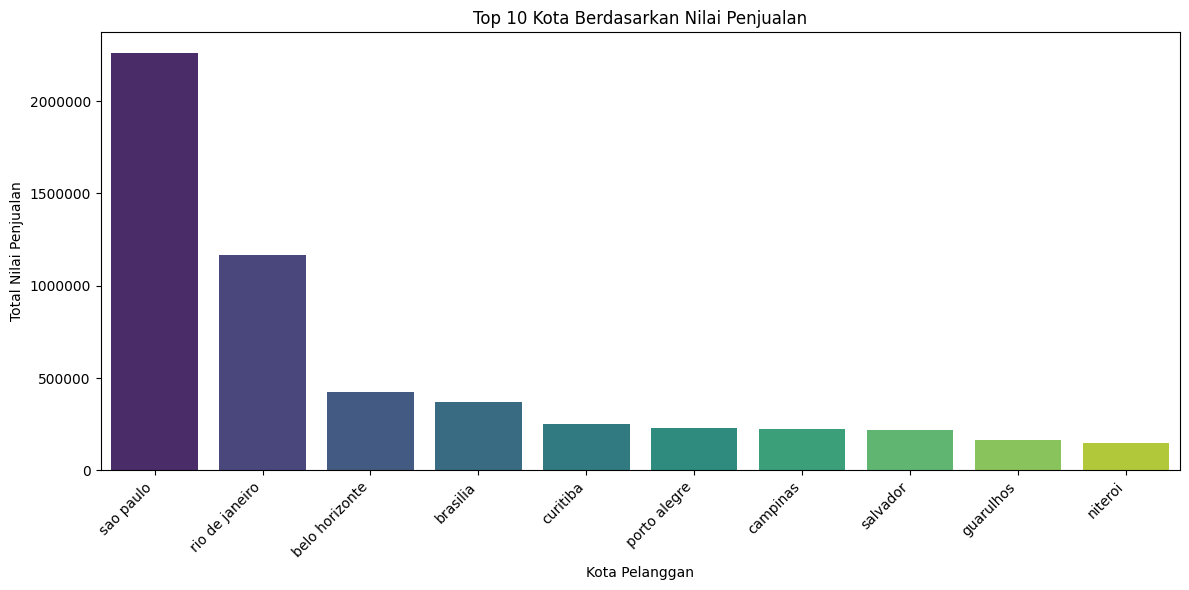

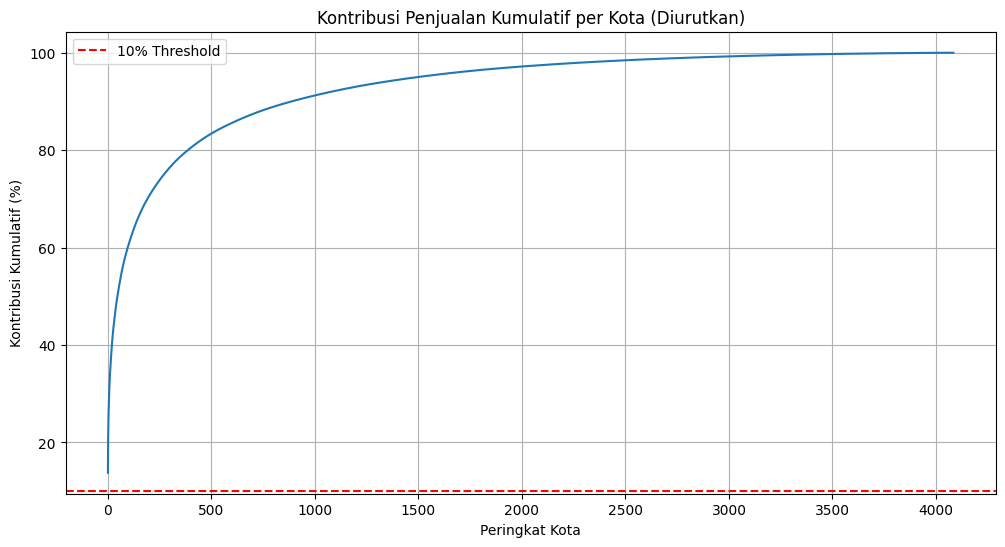

In [15]:
# --- Visualisasi 1: Top 10 Kota Berdasarkan Nilai Penjualan Tertinggi ---
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_city', y='payment_value', data=city_sales.head(10), hue='customer_city', palette='viridis', legend=False)
plt.title('Top 10 Kota Berdasarkan Nilai Penjualan')
plt.xlabel('Kota Pelanggan')
plt.ylabel('Total Nilai Penjualan')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualisasi Kumulatif Kontribusi (ini tetap berguna untuk melihat akumulasi persentase)
plt.figure(figsize=(12, 6))
city_sales['cumulative_contribution'] = city_sales['contribution_percentage'].cumsum()
sns.lineplot(x=range(len(city_sales)), y='cumulative_contribution', data=city_sales)
plt.axhline(y=10, color='r', linestyle='--', label='10% Threshold')
plt.title('Kontribusi Penjualan Kumulatif per Kota (Diurutkan)')
plt.xlabel('Peringkat Kota')
plt.ylabel('Kontribusi Kumulatif (%)')
plt.grid(True)
plt.legend()
plt.show()

### 3.2 Pertanyaan 2: Di kota tersebut, produk apa yang paling dominan, yaitu yang menyumbang minimal 50% dari total nilai transaksi penjualan di kota tersebut?

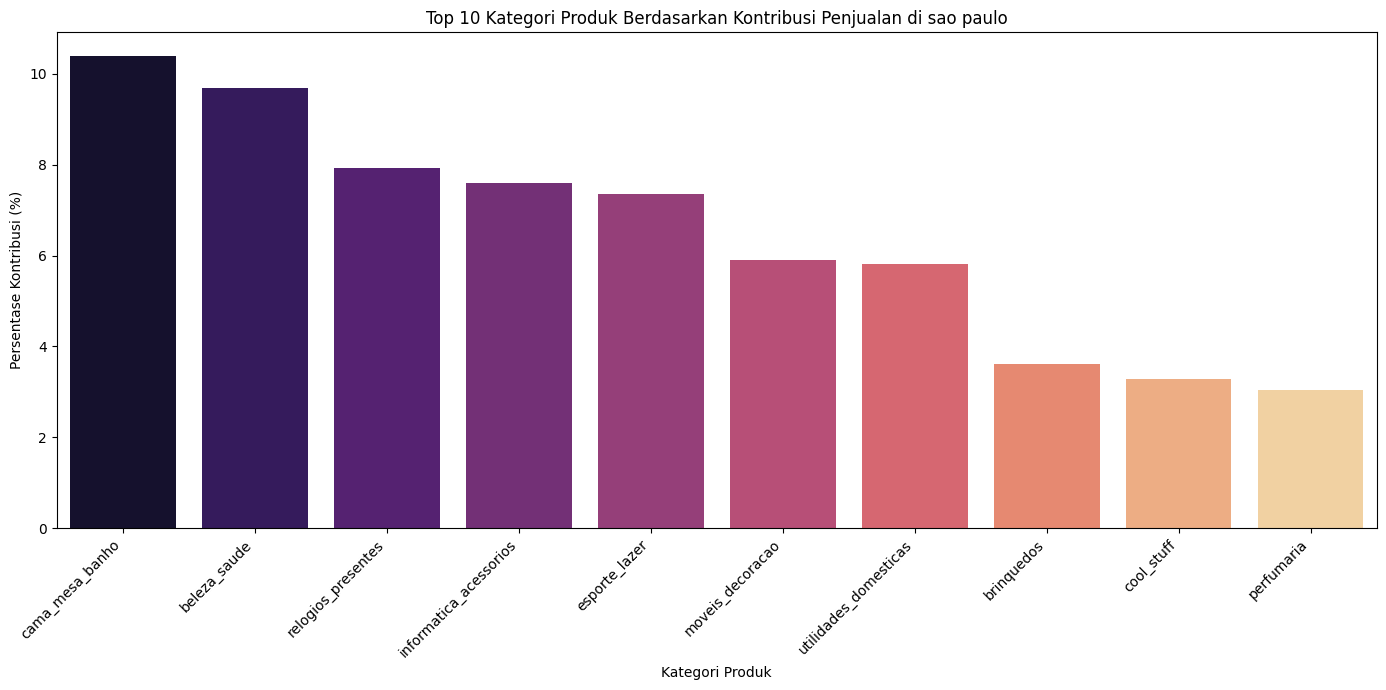

In [16]:
# Visualisasi Kontribusi Produk di Kota Dominan
plt.figure(figsize=(14, 7))
# Perbaikan: Tambahkan hue='product_category_name' dan legend=False
sns.barplot(x='product_category_name', y='contribution_percentage',
            data=product_sales_in_dominant_city.head(10), hue='product_category_name', palette='magma', legend=False)
plt.title(f'Top 10 Kategori Produk Berdasarkan Kontribusi Penjualan di {dominant_city}')
plt.xlabel('Kategori Produk')
plt.ylabel('Persentase Kontribusi (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Conclusion

- Conclution pertanyaan 1:

  Dari hasil analisis, terlihat bahwa Sao Paulo adalah kota dengan kinerja penjualan tertinggi, menyumbang 13.79% dari total nilai transaksi penjualan secara keseluruhan. Ini menjadikannya satu-satunya kota yang memenuhi kriteria kontribusi minimal 10%.

- Conclution pertanyaan 2:

  Meskipun Sao Paulo adalah kota dengan penjualan tertinggi, tidak ada satu pun kategori produk yang secara individual mendominasi pasar di sana. Tidak ada produk yang menyumbang minimal 50% dari total nilai transaksi penjualan di Sao Paulo. Kategori produk teratas adalah "cama_mesa_banho" dengan kontribusi 10.39%, diikuti oleh "beleza_saude" dengan 9.68%. Hal ini mengindikasikan bahwa pasar produk di Sao Paulo sangat beragam dan tidak terlalu bergantung pada satu jenis produk tertentu.